# Bayesian Statistical Inference

G. Richards, 2016 (with input from Ivezic $\S5$, Bevington, Karen Leighly's [Bayesian Stats](http://seminar.ouml.org/lectures/bayesian-statistics/) and [MCMC](http://seminar.ouml.org/lectures/monte-carlo-markov-chain-mcmc/) lectures, and [Thomas Wiecki](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/).)

## Model Fitting: Likelihoods and Posterior PDFs
Let's start with a review of likelihoods and posteriors using some practical examples.

Remember that, for an experiment with data $D=\{x_i\}$ in 1D with Gaussian errors, we have
$$L \equiv p(\{x_i\}|\mu,\sigma) = \prod_{i=1}^N \frac{1}{\sigma\sqrt{2\pi}} \exp\left(\frac{-(x_i-\mu)^2}{2\sigma^2}\right).$$

Let's create some data and see what the resulting likelihood looks like for some example points.

In [1]:
#Load up the algorithms we are going to need.
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
%matplotlib inline
np.random.seed(42)

We are going to draw a homoscedastic sample of ${x_i}$ from a Gaussian and compute the likelihood.

First generate a sample of `N=3` points drawn from a normal distribution with `mu=1.0` and `sigma=0.2`: N(mu,sigma)

In [2]:
N = 3
mu = 1.0
sigma = 0.2 
sample = norm(mu,sigma).rvs(N)
print(sample)

[ 1.09934283  0.97234714  1.12953771]


Now plot each of the likelihoods separately in addition to their product.  Make the $x$ axis a grid of 1000 points uniformly sampled between $x=0$ and $x=2$.

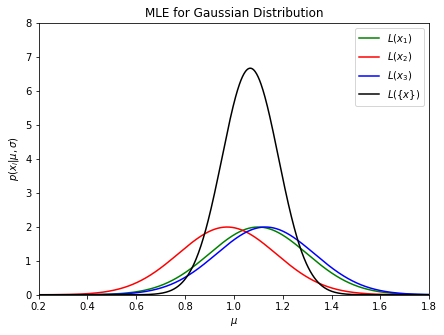

In [9]:
#Make the plot and see if you get the same as me.
muGrid = np.linspace(0,2,1000)
L1 = norm.pdf(muGrid,loc=sample[0],scale=sigma) # likelihood 1
L2 = norm.pdf(muGrid,loc=sample[1],scale=sigma) # likelihood 2
L3 = norm.pdf(muGrid,loc=sample[2],scale=sigma)
L = L1 * L2 * L3 #Total L is ???

fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', label=r'$L(x_1)$')
plt.plot(muGrid, L2, ls='-', c='red', label=r'$L(x_2)$')
plt.plot(muGrid, L3, ls='-', c='blue', label=r'$L(x_3)$')
plt.plot(muGrid, L, ls='-', c='black', label=r'$L(\{x\})$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 8.0)
plt.xlabel('$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(x_i|\mu,\sigma)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()

You should get something that looks like this:

![MLE Example](figures/MLEexample.jpg)

Now we can just read off the maximum likelihood solution.  Use `np.argsort()` to figure out the argument of the largest value and print that index of `muGrid`.

In [10]:
indices = np.argsort(L)
index_max = indices[-1]
print("Likelihood is maximized at %.3f" % muGrid[index_max])

Likelihood is maximized at 1.067


How does our answer change if we include a Bayesian prior (like we assumed for the IQ problem last time) and instead maximize the posterior probability?

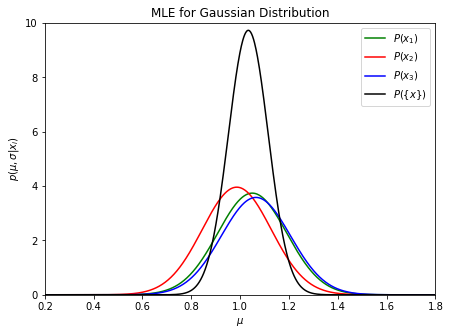

Posterior PDF is maximized at 1.033


In [12]:
Prior = norm.pdf(muGrid,loc=mu,scale=sigma) #Prior PDF
Post1 = Prior*L1 #Posterior PDF for the first measurement
Post2 = Prior*L2
Post3 = Prior*L3
Post = Post1 * Post2 * Post3 #Total posterior PDF for all the measurements

# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, Post1, ls='-', c='green', label=r'$P(x_1)$')
plt.plot(muGrid, Post2, ls='-', c='red', label=r'$P(x_2)$')
plt.plot(muGrid, Post3, ls='-', c='blue', label=r'$P(x_3)$')
plt.plot(muGrid, Post/5, ls='-', c='black', label=r'$P(\{x\})$') #Scaled for the sake of display

plt.xlim(0.2, 1.8)
plt.ylim(0, 10.0)
plt.xlabel('$\mu$') #Leave out or adjust if no latex
plt.ylabel(r'$p(\mu,\sigma|x_i)$') #Leave out or adjust if no latex
plt.title('MLE for Gaussian Distribution')
plt.legend()
plt.show()

idx = np.argsort(Post)
print("Posterior PDF is maximized at %.3f" % muGrid[idx[-1]])

See what happens when you have just 2 measurements, but one has a much larger error than the other (i.e., the errors are heteroscedastic).

Likelihood is maximized at 0.805


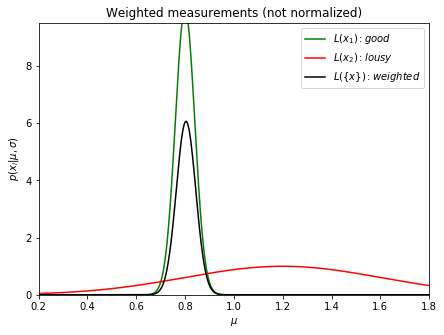

In [17]:
# Made up numbers
L1 = norm.pdf(muGrid,loc=0.8,scale=0.04) #Measurement with small error
L2 = norm.pdf(muGrid,loc=1.2,scale=0.4) #Measurement with large error (give it a very different location parameter)
L = L1 * L2 
# plot
fig, ax = plt.subplots(figsize=(7, 5))
plt.plot(muGrid, L1, ls='-', c='green', label=r'$L(x_1): good$')
plt.plot(muGrid, L2, ls='-', c='red', label=r'$L(x_2): lousy$')
plt.plot(muGrid, L, ls='-', c='black', label=r'$L(\{x\}): weighted$')

plt.xlim(0.2, 1.8)
plt.ylim(0, 9.5)
plt.xlabel('$\mu$')
plt.ylabel(r'$p(x_i|\mu,\sigma)$')
plt.title('Weighted measurements (not normalized)')
plt.legend()

idx = np.argsort(L)
print("Likelihood is maximized at %.3f" % muGrid[idx[-1]])

## Model Fitting: Model Selection

Last time we talk about not just determining the best-fit parameters for your chosen model, but also about how to decide which model is best.

Let's use the example from http://jakevdp.github.io/blog/2015/08/07/frequentism-and-bayesianism-5-model-selection/
to illustrate some ideas about model selection.

In [18]:
#Execute this cell to load all of the modules we'll need and define the data array.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy import optimize

# generate (x,y, sigma_y) "data" 
data = np.array([[ 0.42,  0.72,  0.  ,  0.3 ,  0.15,
                   0.09,  0.19,  0.35,  0.4 ,  0.54,
                   0.42,  0.69,  0.2 ,  0.88,  0.03,
                   0.67,  0.42,  0.56,  0.14,  0.2  ],
                 [ 0.33,  0.41, -0.25,  0.01, -0.05,
                  -0.05, -0.12,  0.26,  0.29,  0.39, 
                   0.31,  0.42, -0.01,  0.58, -0.2 ,
                   0.52,  0.15,  0.32, -0.13, -0.09 ],
                 [ 0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1 ,
                   0.1 ,  0.1 ,  0.1 ,  0.1 ,  0.1  ]])

In [19]:
#Functions to do a polynomial fit, compute the likelihood, and determine the best-fit parameters.
#Nothing for you to do, just run.  (But see if you can follow what is going on.)
def polynomial_fit(theta, x):
    """Polynomial model of degree (len(theta) - 1)"""
    # For just one parameter, this gives theta_1*x
    # For two parameters, this gives theta_1*x + theta_2*x^2, etc.
    return sum(t * x ** n for (n, t) in enumerate(theta))

# compute the data log-likelihood given a model
def logL(theta, data, model=polynomial_fit):
    """Gaussian log-likelihood of the model at theta"""
    x, y, sigma_y = data
    y_fit = model(theta, x)
    return sum(stats.norm.logpdf(*args) for args in zip(y, y_fit, sigma_y))

# a direct optimization approach is used to get best model 
# parameters (which minimize -logL)
def best_theta(degree, model=polynomial_fit, data=data):
    theta_0 = (degree + 1) * [0]
    neg_logL = lambda theta: -logL(theta, data, model)
    return optimize.fmin_bfgs(neg_logL, theta_0, disp=False)

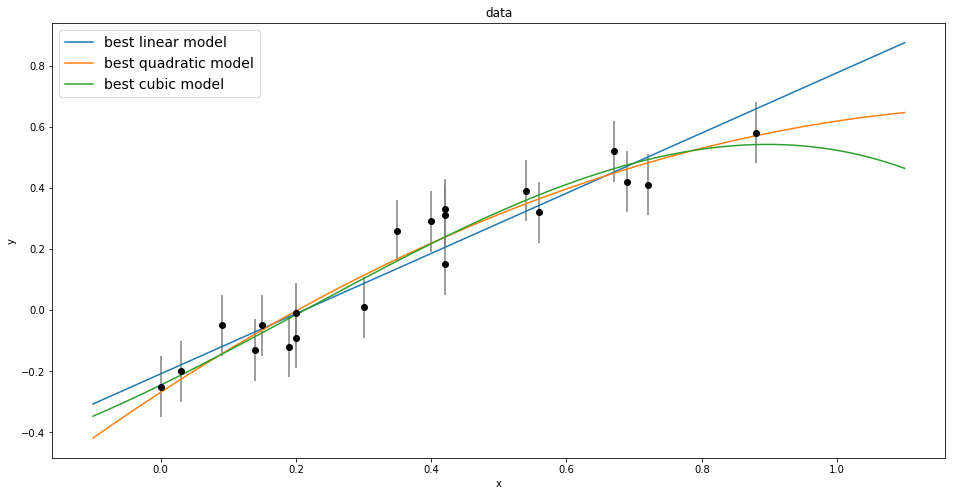

In [20]:
#Execute this cell.  See if you understand what it is doing.
x, y, sigma_y = data
Ndata = x.size

# get best-fit parameters for linear, quadratic and cubic models
theta1 = best_theta(1, data=data)
theta2 = best_theta(2, data=data)
theta3 = best_theta(3, data=data)
# generate best fit lines on a fine grid 
xgrid = np.linspace(-0.1, 1.1, 1000)
yfit1 = polynomial_fit(theta1, xgrid)
yfit2 = polynomial_fit(theta2, xgrid)
yfit3 = polynomial_fit(theta3, xgrid)

# plot 
fig, ax = plt.subplots(figsize=(16, 8))
ax.errorbar(x, y, sigma_y, fmt='ok', ecolor='gray')
ax.plot(xgrid, yfit1, label='best linear model')
ax.plot(xgrid, yfit2, label='best quadratic model')
ax.plot(xgrid, yfit3, label='best cubic model')
ax.legend(loc='best', fontsize=14)
ax.set(xlabel='x', ylabel='y', title='data');

We can use $\chi^2$ per degree of freedom to determine which fit is "best".  It is computed as 
$$ \chi^2_{dof}  = \frac{1}{N-k} \sum_i^N \left( \frac{y - y_{fit}}{\sigma_y} \right)^2, $$
where $N$ is the number of data points and $k$ is the number of free model parameters (here 2, 3, and 4).

For large values of $(N-k)$ (larger than about 10), the distribution of 
$\chi^2$ per degre of freedom is approximately Gaussian with a width of
$\sigma=\sqrt{2/(N-k)}$. 

In [22]:
#Complete and execute this cell to compute chi2: sum{[(y-yfit)/sigma_y]^2} 
chi21 = np.sum(((y-polynomial_fit(theta1, x))/sigma_y)**2) # just 1
chi22 = np.sum(((y-polynomial_fit(theta2, x))/sigma_y)**2) # 1 & 2
chi23 = np.sum(((y-polynomial_fit(theta3, x))/sigma_y)**2) # 1, 2, & 3
# normalize by the number of degrees of freedom
# the number of fitted parameters is 2, 3, 4
chi2dof1 = chi21/(Ndata - 2)
chi2dof2 = chi22/(Ndata - 3)
chi2dof3 = chi23/(Ndata - 4)

print("CHI2:")
print('   best linear model:', chi21)
print('best quadratic model:', chi22)
print('    best cubic model:', chi23)
print("CHI2 per degree of freedom:")
print('   best linear model:', chi2dof1)
print('best quadratic model:', chi2dof2)
print('    best cubic model:', chi2dof3)

CHI2:
('   best linear model:', 11.499462014956965)
('best quadratic model:', 9.2912582461163655)
('    best cubic model:', 8.9792082946770613)
CHI2 per degree of freedom:
('   best linear model:', 0.63885900083094249)
('best quadratic model:', 0.54654460271272742)
('    best cubic model:', 0.56120051841731633)


**Which model should we adopt?**

Obviously, the cubic model has the lowest $\chi^2$ ("fits the best"), but 
it has 4 free parameters while the linear model has only 2 free parameters.  Let's use the BIC and AIC to determine if we are perhaps **over** fitting.

The **Aikake information criterion (AIC)**, for $N$ data points and a model with $k$ parameters, is computed as
$${\rm AIC} \equiv -2 \ln (L_0(M)) + 2k + \frac{2k(k+1)}{N-k-1},$$
where the 2nd and 3rd terms are designed to penalize complex models relative to simple ones.

The **Bayesian information criterion (BIC)** is computed as
$${\rm BIC} \equiv -2 \ln (L_0(M)) + k \ln N.$$ 

('-logL:', array([-11.92320019, -13.02730207, -13.18332705]))
('AIC:', array([-19.14051802, -18.55460415, -15.69998743]))
('BIC:', array([-17.85493583, -14.85920356, -11.86347128]))
[-11.92320019 -13.02730207 -13.18332705]
[-17.85493583 -14.85920356 -11.86347128]
[-19.14051802 -18.55460415 -15.69998743]


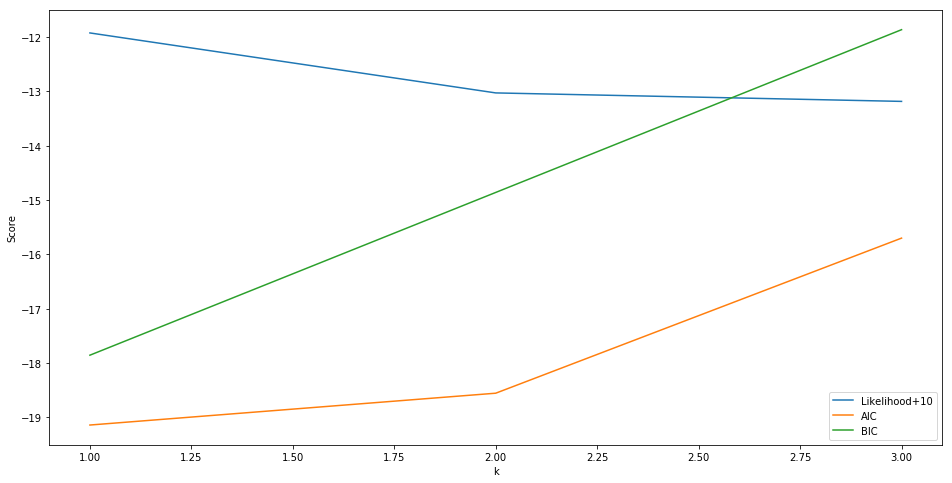

In [23]:
#Complete and execute this cell
L = [] #Array with all of the likelihood values
A = [] #Array with all of the AIC values
B = [] #Array with all of the  BICvalues
neg_LogL1 = -logL(theta1, data)+10  #+10 for plotting purposes
neg_LogL2 = -logL(theta2, data)+10
neg_LogL3 = -logL(theta3, data)+10
L = np.append(L,neg_LogL1)
L = np.append(L,neg_LogL2)
L = np.append(L,neg_LogL3)

xplot = np.arange(len(L))+1 #x values for plotting.

AIC1 = 2.*neg_LogL1 + 2.*len(theta1) + 2.*len(theta1)*(len(theta1)+1)/(len(data[0])-len(theta1)-1)
AIC2 = 2.*neg_LogL2 + 2.*len(theta2) + 2.*len(theta2)*(len(theta2)+1)/(len(data[0])-len(theta2)-1) #Complete
AIC3 = 2.*neg_LogL3 + 2.*len(theta3) + 2.*len(theta3)*(len(theta3)+1)/(len(data[0])-len(theta3)-1) #Complete
A = np.append(A,AIC1)
A = np.append(A,AIC2)
A = np.append(A,AIC3)
BIC1 = 2.*neg_LogL1 + len(theta1)*np.log(len(data[0]))
BIC2 = 2.*neg_LogL1 + len(theta2)*np.log(len(data[0])) #Complete
BIC3 = 2.*neg_LogL1 + len(theta3)*np.log(len(data[0])) #Complete
B = np.append(B,BIC1)
B = np.append(B,BIC2)
B = np.append(B,BIC3)

print("-logL:", L)
print("AIC:", A)
print("BIC:", B)


fig = plt.subplots(figsize=(16, 8))
plt.plot(xplot, L, label='Likelihood+10')
plt.plot(xplot, A, label='AIC')
plt.plot(xplot, B, label='BIC')
plt.legend()
plt.xlabel("k")
plt.ylabel("Score")
print(L)
print(B)
print(A)

How do we interpret this?

ANS: Can use a linear fit.

How far do you have to move the last data point to the right to have the best fit be quadratic instead of linear?

## Model Comparison

In the Bayesian context, to determine which model is better we compute the ratio of the posterior probabilities or the **odds ratio** for two models as
$$O_{21} \equiv \frac{p(M_2|D,I)}{p(M_1|D,I)}.$$

Since 
$$p(M|D,I) = \frac{p(D|M,I)p(M|I)}{p(D|I)},$$
the odds ratio can ignore $p(D|I)$ since it  will be the same for both models.  

(That is even more important than you might think as the denominator is the integral of the numerator, but what if you don't have an analytical function that you can integrate?!)

### How do we interpret the values of the odds ratio in practice?

Jeffreys proposed a five-step scale for interpreting the odds ratio, where $O_{21} > 10$ represents “strong” evidence in favor of $M_2$ ($M_2$ is ten times more probable than $M_1$), and $O_{21} > 100$ is “decisive” evidence ($M_2$ is one hundred times more probable than $M_1$). When $O_{21} < 3$, the evidence is “not worth more than a bare mention.”

But note:
  * These are just **definitions of conventions**, i.e., a way to give a quantitative meaning to qualitative phrases.
  * The odds ratio **compares** the models, it doesn't tell us about the *absolute* goodness of fit: model A can be 100x better than model B, but still be pretty lousy.

### Hypothesis Testing

In *hypothesis testing* we are essentially comparing a model, $M_1$, to its complement.  That is $p(M_1) + p(M_2) = 1$.  If we take $M_1$ to be the "null" (default) hypothesis (which is generally that, for example, a correlation does *not* exist), then we are asking whether or not the data reject the null hypothesis.

In classical hypothesis testing we can ask whether or not a single model provides a good description of the data.  

In Bayesian hypothesis testing, we need to have an alternative model to compare to.

### Coin Flip as an Example of Bayesian Model Comparison

Let's look at an example using coin flips. Let's assume we have $N$ draws and $k$ are "success" (say, heads). 

We will compare two hypotheses:

**M1**: the coin has a known heads probability $b_\ast$ (say, a fair coin with $b_\ast=0.5$), with a prior given by a delta function, $\delta(b-b_\ast)$,

and

**M2**: the heads probability $b$ is unknown, with a uniform prior in the range 0–1.

The model that we need (parametrized by the probability of success $b$, with $k$ successes) is the binomial distribution (which we haven't talked about yet): 
  $$    p(k\,|\,b, N) = \frac{N!}{k! \, (N-k)!} \, b^k \, (1-b)^{N-k} $$

For model M2 the prior for $b$ is flat in the range 0-1 and the product of the 
data likelihood and prior is same as above. However, for model M1 the prior is a 
delta function $\delta(b-b_\ast)$ and we get for the product of the 
data likelihood and prior  
$$    p(k\,|\,b_\ast, N, M1)\,p(b|M1, I) = \frac{N!}{k! \, (N-k)!} \, b_\ast^k \, (1-b_\ast)^{N-k}. $$

Consequently, the odds ratio is given by 
$$ O_{21} = \int_0^1 \left(\frac{b}{b_\ast}\right)^k \left(\frac{1-b}{1-b_\ast}\right)^{N-k} db, $$
as illustrated in the following figure. 

 
![Ivezic, Figure 5.1](http://www.astroml.org/_images/fig_odds_ratio_coin_1.png)

This figure (from the textbook) illustrates the behavior of $O_{21}$ as a function of $k$
for two different values of N and for two different values of $b_\ast$: $b_\ast = 0.5$ 
(M1: the coin is fair) and $b_\ast = 0.1$ (M1: the coin is biased to tails). As the figure shows, the ability to distinguish 
the two hypothesis **improves** with the sample size. 

For example, when $b_\ast= 0.5$ and 
k/N = 0.1, the odds ratio in favor of M2 (that the coin may not be fair) increases from about 9 for N = 10 to about 
263 for N = 20. When k = $b_\ast N$, the odds ratio is 0.37 for N = 10 and 0.27 for N = 20. 
In other words, **the simpler model is favored by the data**, and the support strengthens 
with the sample size. 

Integration of the above equation reveals that 
$O_{21}= \sqrt{\pi/(2N)}$ when k = $b_\ast N$ and $b_\ast = 0.5$. For example, to build strong 
evidence that a coin is fair, $O_{21} < 0.1$, it takes as many as N $>$ 157 tosses. With 
N = 10,000, the heads probability of a fair coin is measured with a precision of 1% and
the corresponding odds ratio is $O_{21} \approx 1/80$, approaching Jeffreys’ decisive 
evidence level. 

In **frequentist approach**, we would ask whether we can reject the "null hypothesis" that 
our coin is fair. We would ask whether a given $k$ is a very unusual outcome (at some 
significance level $\alpha$, say $\alpha=0.05$, which corresponds to about "2$\sigma$"
deviation) for a fair coin with $b_\ast = 0.5$ and with
a given N. In the **Bayesian approach**, we offer an alternative hypothesis that the coin 
has an unknown heads probability. While this probability can be estimated from provided 
data ($b_0$), **we consider all the possible values** of $b_0$ when comparing the two proposed 
hypotheses. 

As a numerical example, let's consider N=20 and k=16. The scatter around the expected value $k_0 = b_\ast N$ = 10 is $\sigma_k = 2.24$. 
Therefore, k = 16 is about 2.7$\sigma_k$ away from $k_0$, and at the adopted significance 
level $\alpha=0.05$ we **reject the null hypothesis** (this rejection means that it is unlikely that k = 16 would have arisen by chance). Of course, k = 16 does **not** imply 
that it is impossible that the coin is fair (infrequent events happen, too!).

As shown in the above figure, the chosen parameters (N=20 and k=16) correspond to the 
Bayesian **odds ratio** of about 10 in favor of hypothesis M2.  

## Markov-Chain Monte Carlo Methods

### Motivation

Consider the problem of estimating location and scale parameters
for a sample drawn from a Gaussian distribution that we introduced earlier.
We had a two-dimensional posterior pdf for $\mu$ and $\sigma$:

![Ivezic, Figure 5.5](http://www.astroml.org/_images/fig_likelihood_gaussian_1.png)


It was easy to numerically integrate the posterior pdf, as well 
as to find its maximum, using brute force grid search because
it was only a two-dimesional problem. With 100 grid points per
coordinate it was only $10^4$ values. However, even in a case
of rather simple 5-dimensional problem (as we'll discuss later 
today), we'd have $10^{10}$ values! And often we work with models 
of much higer dimensionality (it can be thousands). 

You could simply randomly sample the grid at every point, and try to find the minimum based on that. But that can also be quite time consuming, and you will spend a lot of time in regions of parameter space that yields small likelihood.

A better way is to adopt a Markov-Chain Monte Carlo (MCMC). MCMC gives us a way to make this problem computationally tractable by sampling the full multi-dimensional parameter space, in a way that builds up the most density in the regions of parameter space which are closest to the maximum. Then, you can post-process the “chain” to infer the distribution and error regions.

Ivezic, Figure 5.22 shows a problem similar to the one above, done with a Markov Chain Monte Carlo.  The dashed lines are the known (analytic) solution.  The solid lines are from the MCMC estimate with 10,000 sample points.
![Ivezic, Figure 5.10](http://www.astroml.org/_images/fig_cauchy_mcmc_1.png)


## How does MCMC work?

I've really struggled to come up with a simple way of illustrating MCMC so that you (and I for that matter) can understand it.  Unfortunately, even the supposedly dumbed-down explanations are really technical.   But let's see what I can do!  

Let's start by simply trying to understand what a Monte Carlo is and what a Markov Chain is.

### What is a Monte Carlo?

In case you are not familiar with Monte Carlo methods, it might help to know that the term is derived from the name of an administrative area of the Principality of Monaco (Monte Carlo) where they are known for gambling.  And gambling and random sampling go together.

We'll consider a simple example: you have forgotten the value of $\pi$, but you know the formula for the area of a square and how to draw a circle. 

We can use the information that we *do* know to numerically compute $\pi$.

We start by drawing a square and circumscribing a circle in it (actually it suffices to just do a quarter of a circle and scale accordingly).  Then we put down random points within the square and note which ones land in the circle.  The ratio of random points in the circle to the number of random points drawn is related to the area of our circle, allowing us to calculate $\pi$.  Using more random points yields more precise estimates of the area.

Try it.

We'll consider one quadrant of a square of sides [-1,1] in which we inscribe a circle.

Text(0,0.5,u'y')

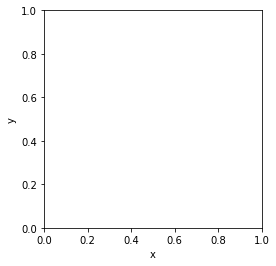

In [24]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
ax.axis([0, 1, 0, 1], aspect='equal');
plt.xlabel('x')
plt.ylabel('y')

Estimate of pi is 3.116 for 1000 draws with fractional error 0.00814639465131.


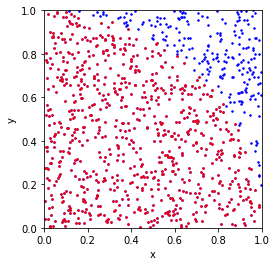

In [25]:
#Lay down M random points.  Tally how many are within a unit circle.
M = 1000
x = stats.uniform(0,1).rvs(M) #M random draws between 0 and 1
y = stats.uniform(0,1).rvs(M) #M random draws between 0 and 1
r2 = x**2 + y**2 #Radius of cirle
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
plt.plot(x, y, '.k', markersize=3, c='blue') #Plot points in square
plt.plot(x[r2<1], y[r2<1], '.k', markersize=3, c='red') #Plot points also in circle
ax.axis([0, 1, 0, 1], aspect='equal');
plt.xlabel('x')
plt.ylabel('y')
    
#Asquare = d^2, Acircle = pi*d^2

piEst = 4.0*np.sum(r2<1)/M # pi = 4A/d^2, where A is d^2 times the ratio of points "in" to total points

print("Estimate of pi is {0} for {1} draws with fractional error {2}.".format(piEst,M,np.abs((np.pi-piEst)/np.pi)))

See how many draws does it take to get the error down to 1 part in a thousand?

In general, Monte Carlo methods are about using random sampling to obtain a numerical result (e.g., the value of an integral), where there is no analytic result.

In the case of the circle above, we have computed the intergral:
$$\int\int_{x^2+y^2\le 1} dx dy.$$

### What is a Markov Chain?

A Markov Chain is defined as a sequence of random variables where a parameter depends *only* on the preceding value.  Such processes are "memoryless".  
 
Mathematically, we have
$$p(\theta_{i+1}|\{\theta_i\}) = p(\theta_{i+1}|\theta_i).$$

Now, if you are like me, you might look at that and say "Well, day 3 is based on day 2, which is based on day 1, so day 3 is based on day 1...".

So let's look at an example to see what we mean and how this might be a memoryless process.


Let's say that you are an astronomer and you want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy).  From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$
which means that
$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have
$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$
which means that
$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$

(That is, you don't live in Philadelphia.)

We can start with the sky conditions today and make predictions going forward.  This will look like a big decision tree.  After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$
and 
$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether is was clear to cloudy on the day that you started.    

The steps that we have taken in this process are a **Markov Chain**.

Sampling for 10,000 days using this prescription gives a chain that looks like this:

![Chain Figure](../figures/Chain.png)

For homework, you will generate an equivalent plot, testing to see whether or not it matters if you start on a clear day or a cloudy day.

A histogram of the above plot reveals the distribution of p(clear) values over this time.  We can use this to determine the most likely value and an error on our estimate.

![ChainHist Figure](../figures/ChainHist.png)

In MCMC the process must be **stationary** which basically means that its looks the same no matter where you sample it.  

Obviously that isn't going to be the case in the early steps of the chain.  In our example above, after some time the process was stationary, but not in the first few days.

So, there is a **burn-in** phase that needs to be discarded.  How one determines how long many iterations the burn-in should last when you don't know the distribution can be a bit tricky.

## Markov Chain Monte Carlo Summary

1. Starting at a random position, evaluate the likelihood.
2. Choose a new position, according to some transition probabilities, and evaluate the likelihood there.
3. Examine the odds ratio formed by the new-position likelihood and the old-position likelihood. If the odds ratio is greater than 1, move to the new position.  If it is less than one, keep it under the following conditions: draw a random number between zero and 1.   If the odds ratio is larger than the random number, keep it. If not, reject the new position.
4. Repeat 1-3 many times. After a period of time (the burn-in) the simulation should reach an equilibrium. Keep the results of the chain (after burn-in), and postprocess those results to infer the likelihood surface.


Most of the difficulty in the MCMC process comes from either determining the burn-in or deciding how to step from one position to another.  In our circle example we have drawn points in a completely random manner.  However, that may not be the most efficient manner to span the space.  

The most commonly used algorithm for stepping from one position to another is the [Metropolis-Hastings] (https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm.  

In astronomy, the ${\tt emcee}$ algorithm has become more popular in recent years.  We won't discuss either in detail, but both the [code](http://dan.iel.fm/emcee/current/) and a [paper[(http://adsabs.harvard.edu/abs/2013PASP..125..306F) describing the ${\tt emcee}$ are available.

Recall that our parameter space is multidimensional.  So, when you are stepping from one point to another, you are really doing it in N-D parameter space!  You might wonder if you could just step one parameter at a time.  Sure!  That's what [Gibbs sampling](https://en.wikipedia.org/wiki/Gibbs_sampling) does (and it is less likely to get stuck in a local minimum than Metropolis-Hastings).


Then end result of this process will be a chain of likelihoods that we can use to compute the likelihood contours.  

If you are using MCMC, then you probably have multiple paramters (otherwise, you'd be doing something easier).  So, it helps to display the parameters two at a time, marginalizing over the other parameters.  An example is given in Ivezic, Figure 5.24, which compares the model results for a single Gaussian fit to a double Gaussian fit:

![Ivezic, Figure 5.24](http://www.astroml.org/_images/fig_model_comparison_mcmc_1.png)

We'll end by going through the example given at
[http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/](http://twiecki.github.io/blog/2015/11/10/mcmc-sampling/).

First set up some stuff by executing the next cell

In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(123)

Now let's generate some data points and plot them.  We'll try a normal distribution, centered at 0 with 100 data points.  Our goal is to estimate $\mu$.

Text(0, 0.5, 'N')

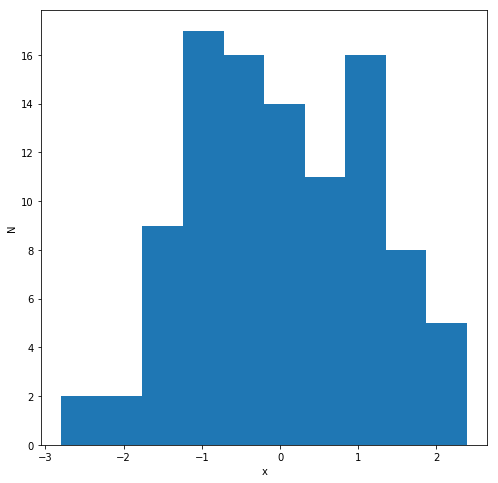

In [2]:
data = np.random.randn(100)
plt.figure(figsize=(8,8))
plt.hist(data)
plt.xlabel('x')
plt.ylabel('N')

Now we have to pick a model to try.  For the sake of simplicity for this example, we'll assume a normal distribution: $\mathscr{N}(\mu,\sigma=1)$ (i.e., with $\sigma=1$).  We'll also assume a normal distribution for the prior on $\mu$: $\mathscr{N}(0,1)$.

We can use that to write a function for our posterior distribution as follows:

Text(0, 0.5, 'post prob')

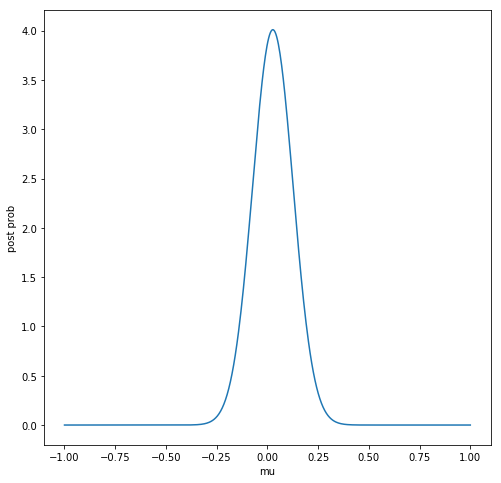

In [3]:
#Execute this cell
def calc_posterior_analytical(data, xgrid, mu_0, sigma_0):
    sigma = 1.
    n = len(data)
    #Error-weighted sum of prior and average of data
    mu_post = (mu_0 / sigma_0**2 + data.sum() / sigma**2) / (1. / sigma_0**2 + n / sigma**2)
    var_post = (1. / sigma_0**2 + n / sigma**2)**-1
    return norm.pdf(xgrid,mu_post, np.sqrt(var_post))

plt.figure(figsize=(8,8))
xgrid = np.linspace(-1, 1, 500)
posterior_analytical = calc_posterior_analytical(data, xgrid, 0., 1.)
plt.plot(xgrid, posterior_analytical)
plt.xlabel('mu')
plt.ylabel('post prob')

Now we need to sample the distribution space.  Let's start by trying $\mu_0 = 0$ and evaluate.

Then we'll jump to a new position using one of the algorithms mentioned above.  In this case we'll use the Metropolis algorithm, which draws the new points from a normal distribution centered on the current guess for $\mu$.

Next we evaluate whether that jump was "good" or not -- by seeing if the value of likelihood\*prior increases.  Now, we want to get the right answer, but we also want to make sure that we sample the full parameter space (so that we don't) get stuck in a local minimum.  So, even if the this location is not better than the last one, we'll have some probability of staying there anyway.  

The reason that taking the ratio of likelihood\*prior works is that the denominator drops out.  That's good because the denominator is the integral of the numerator and that's what we are trying to figure out!  In short, we don't have to know the posterior probability to know that the posterior probability at one step is better than another.

In [5]:
# Execute this cell
# See https://github.com/twiecki/WhileMyMCMCGentlySamples/blob/master/content/downloads/notebooks/MCMC-sampling-for-dummies.ipynb
def sampler(data, samples=4, mu_init=.5, proposal_width=0.5, plot=False, mu_prior_mu=0, mu_prior_sd=1.):
    mu_current = mu_init
    posterior = [mu_current]
    for i in range(samples):
        # suggest new position
        mu_proposal = norm(mu_current, proposal_width).rvs()

        # Compute likelihood by multiplying probabilities of each data point
        likelihood_current = norm(mu_current, 1).pdf(data).prod()
        likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
        
        # Compute prior probability of current and proposed mu        
        prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
        prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
        
        p_current = likelihood_current * prior_current
        p_proposal = likelihood_proposal * prior_proposal
        
        # Accept proposal?
        p_accept = p_proposal / p_current
        
        # Usually would include prior probability, which we neglect here for simplicity
        # Accept if p_accept>1 (since random limited to [0,1]) and if p_accept > rand as well
        accept = np.random.rand() < p_accept
        
        if plot:
            plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accept, posterior, i)
        
        if accept:
            # Update position
            mu_current = mu_proposal
        
        posterior.append(mu_current)
        
    return posterior

# Function to display
def plot_proposal(mu_current, mu_proposal, mu_prior_mu, mu_prior_sd, data, accepted, trace, i):
    from copy import copy
    trace = copy(trace)
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, figsize=(16, 4))
    fig.suptitle('Iteration %i' % (i + 1))
    xgrid = np.linspace(-3, 3, 5000)
    color = 'g' if accepted else 'r'
        
    # Plot prior
    prior_current = norm(mu_prior_mu, mu_prior_sd).pdf(mu_current)
    prior_proposal = norm(mu_prior_mu, mu_prior_sd).pdf(mu_proposal)
    prior = norm.pdf(xgrid,mu_prior_mu, mu_prior_sd)
    ax1.plot(xgrid, prior)
    ax1.plot([mu_current] * 2, [0, prior_current], marker='o', color='b')
    ax1.plot([mu_proposal] * 2, [0, prior_proposal], marker='o', color=color)
    ax1.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax1.set(ylabel='Probability Density', title='current: prior(mu=%.2f) = %.2f\nproposal: prior(mu=%.2f) = %.2f' % (mu_current, prior_current, mu_proposal, prior_proposal))
    
    # Likelihood
    likelihood_current = norm(mu_current, 1).pdf(data).prod()
    likelihood_proposal = norm(mu_proposal, 1).pdf(data).prod()
    y = norm.pdf(xgrid,loc=mu_proposal, scale=1)
    #sns.distplot(data, kde=False, norm_hist=True, ax=ax2)
    ax2.hist(data,alpha=0.5,normed='True')
    ax2.plot(xgrid, y, color=color)
    ax2.axvline(mu_current, color='b', linestyle='--', label='mu_current')
    ax2.axvline(mu_proposal, color=color, linestyle='--', label='mu_proposal')
    #ax2.title('Proposal {}'.format('accepted' if accepted else 'rejected'))
    ax2.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    ax2.set(title='likelihood(mu=%.2f) = %.2f\nlikelihood(mu=%.2f) = %.2f' % (mu_current, 1e14*likelihood_current, mu_proposal, 1e14*likelihood_proposal))
    
    # Posterior
    posterior_analytical = calc_posterior_analytical(data, xgrid, mu_prior_mu, mu_prior_sd)
    ax3.plot(xgrid, posterior_analytical)
    posterior_current = calc_posterior_analytical(data, mu_current, mu_prior_mu, mu_prior_sd)
    posterior_proposal = calc_posterior_analytical(data, mu_proposal, mu_prior_mu, mu_prior_sd)
    ax3.plot([mu_current] * 2, [0, posterior_current], marker='o', color='b')
    ax3.plot([mu_proposal] * 2, [0, posterior_proposal], marker='o', color=color)
    ax3.annotate("", xy=(mu_proposal, 0.2), xytext=(mu_current, 0.2),
                 arrowprops=dict(arrowstyle="->", lw=2.))
    #x3.set(title=r'prior x likelihood $\propto$ posterior')
    ax3.set(title='posterior(mu=%.2f) = %.5f\nposterior(mu=%.2f) = %.5f' % (mu_current, posterior_current, mu_proposal, posterior_proposal))
    
    if accepted:
        trace.append(mu_proposal)
    else:
        trace.append(mu_current)
    ax4.plot(trace)
    ax4.set(xlabel='iteration', ylabel='mu', title='trace')
    plt.tight_layout()
    #plt.legend()

To visualize the sampling, we'll create plots for some quantities that are computed. Each row below is a single iteration through our Metropolis sampler.

The first column is the prior distribution -- our belief about $\mu$ before seeing the data.  The distribution is static and we are only plugging in our $\mu$ proposals. The vertical lines represent the current $\mu$ in blue and the proposed $\mu$ in either red or green (rejected or accepted, respectively).

The 2nd column is the likelihood -- what we are using to evaluate how good our model explains the data.  The likelihood function changes in response to the proposed $\mu$. The blue histogram is the data. The solid line in green or red is the likelihood with the currently proposed mu. The more overlap there is between likelihood and data, the better the model explains the data and the higher the resulting probability will be. The dashed line of the same color is the proposed mu and the dashed blue line is the current mu.

The 3rd column is the (normalized) posterior distribution.

The 4th column is the trace (i.e. the posterior samples of $\mu$ we are generating) where we store each sample irrespective of whether it was accepted or rejected (in which case the line just stays constant).

Note that we always move to relatively more likely $\mu$ values (in terms of their posterior density), but only sometimes to relatively less likely $\mu$ values, as can be seen in iteration 14 (the iteration number can be found at the top center of each row).


/home/dude/other/anaconda/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


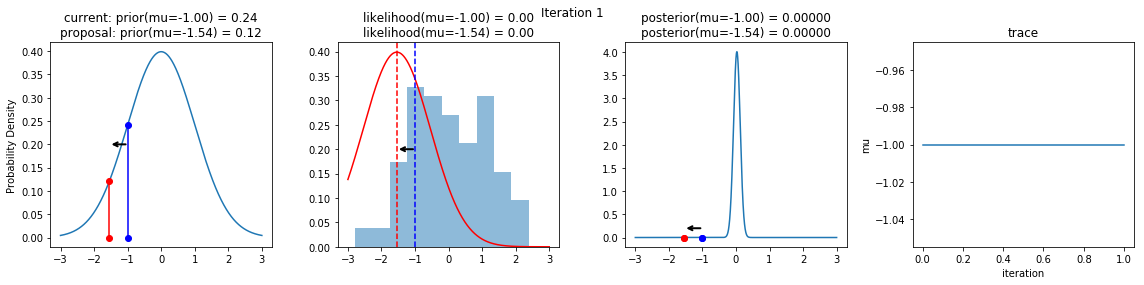

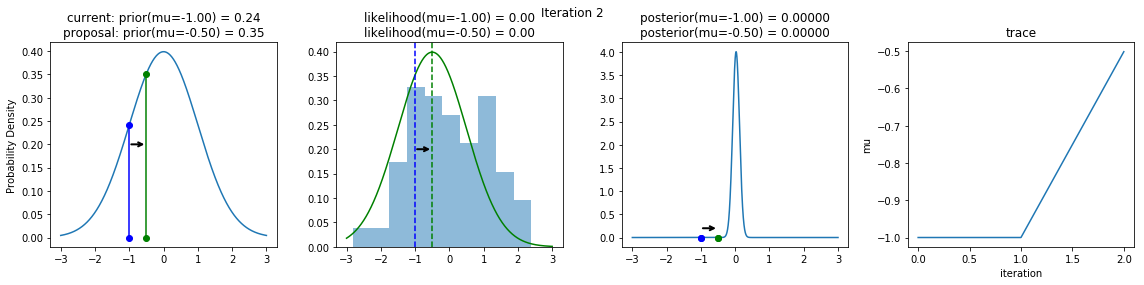

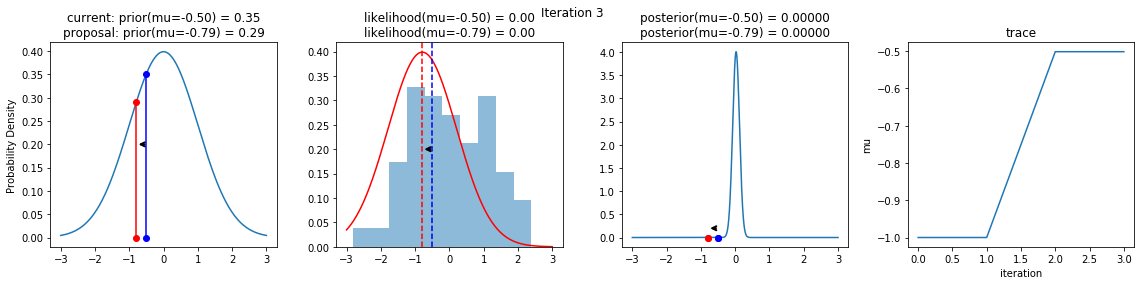

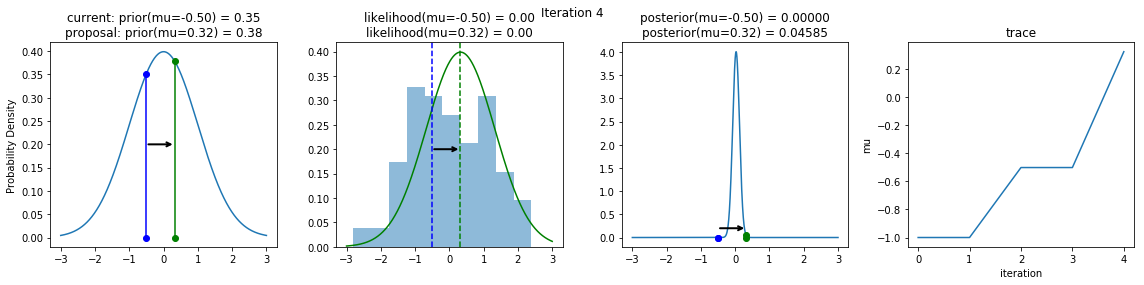

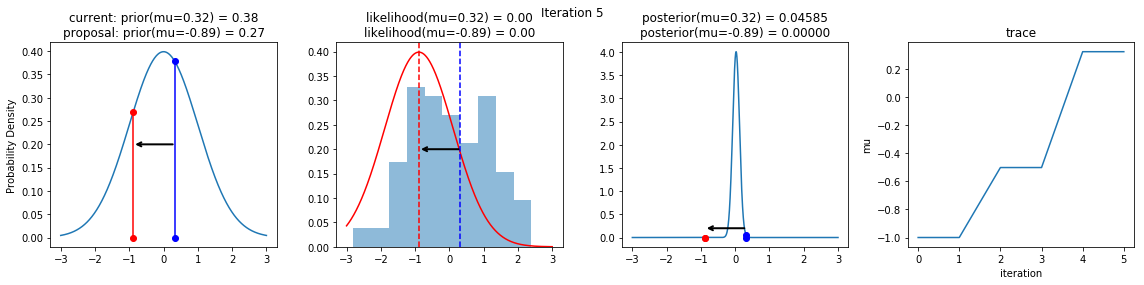

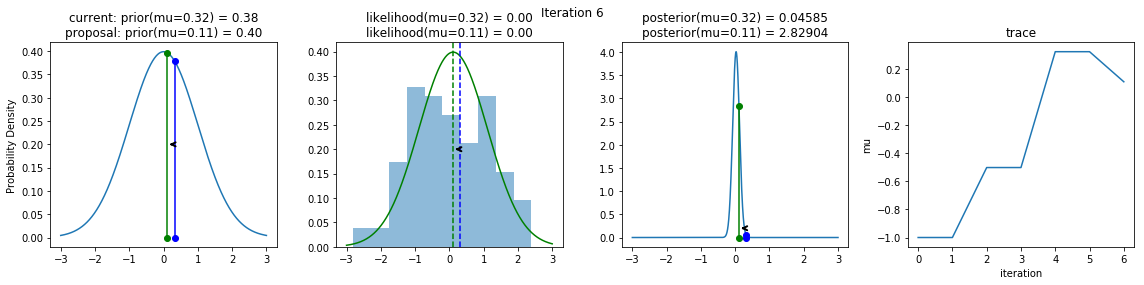

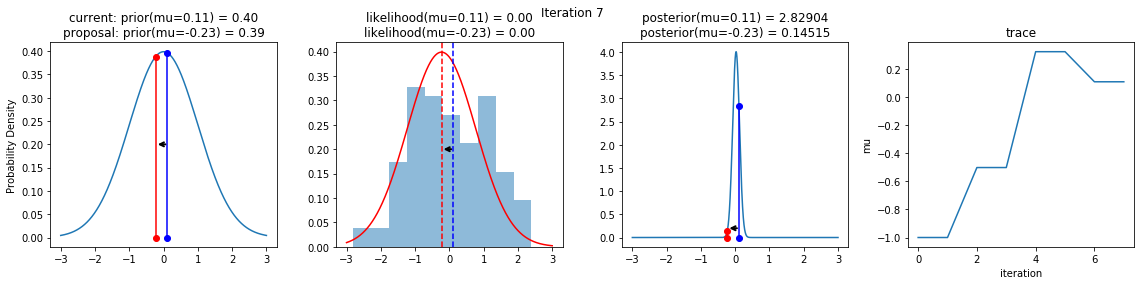

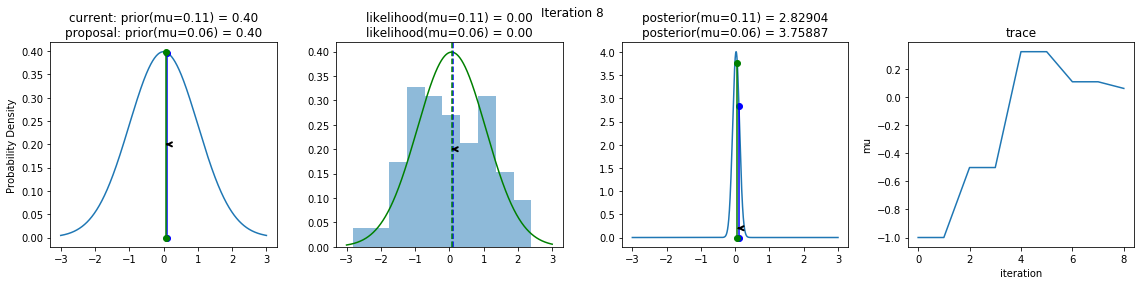

In [6]:
np.random.seed(123)
sampler(data, samples=8, mu_init=-1., plot=True);

What happens when we do this lots of times?

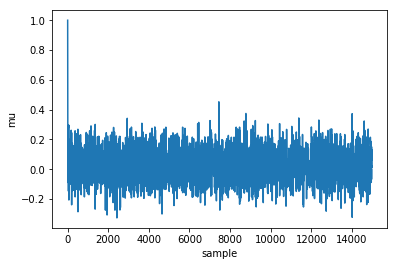

In [7]:
posterior = sampler(data, samples=15000, mu_init=1.)
fig, ax = plt.subplots()
ax.plot(posterior)
_ = ax.set(xlabel='sample', ylabel='mu');

Making a histogram of these results is our estimated posterior probability distribution.

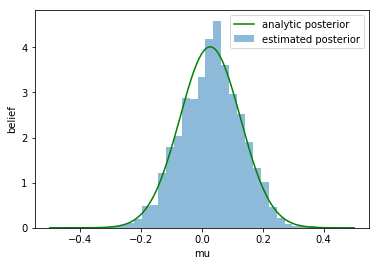

In [12]:
ax = plt.subplot()

ax.hist(posterior[500:],bins=30,alpha=0.5,normed='True',label='estimated posterior')
x = np.linspace(-.5, .5, 500)
post = calc_posterior_analytical(data, x, 0, 1)
ax.plot(x, post, 'g', label='analytic posterior')
_ = ax.set(xlabel='mu', ylabel='belief');
ax.legend(fontsize=10);

Our algorithm for deciding where to move to next used a normal distribution where the mean was the current value and we had to assume a width.  Find where we specified that and see what happens if you make it a lot smaller or a lot bigger.

### More Complex Models

The example above was overkill in that we were only trying to estmate $\mu$.  Note also that we can do this in less than 10 lines using the ${\tt pymc3}$ module.

The process is essentially the same when you add more parameters.  Check out this [animation of a 2-D process](http://twiecki.github.io/blog/2014/01/02/visualizing-mcmc/) by the same author whose example we just followed.

###  Markov Chain Monte Carlo in Practice

For more involved examples, we will use two popular python modules:
PyMC and emcee. Quoting 
[Jake's blog:](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/)

** emcee **

*The emcee package (also known as MCMC Hammer, which is in the running for best Python package name in history) is a Pure Python package written by Astronomer Dan Foreman-Mackey. It is a lightweight package which implements a fairly sophisticated Affine-invariant Hamiltonian MCMC. Because the package is pure Python (i.e. it contains no compiled extensions) it is extremely easy to install; with pip, simply type at the command-line "pip install emcee".*

*Emcee does not have much specific boilerplate code; it simply requires you to pass it a Python function which returns a value proportional to the log-posterior probability, and returns samples from that posterior.*

** PyMC **

*The PyMC package has many more features than emcee, including built-in support for efficient sampling of common prior distributions. PyMC by default uses the classic Metropolis-Hastings sampler, one of the earliest MCMC algorithms. For performance, it uses compiled fortran libraries, so it is less trivial to install using tools like pip. PyMC binaries for many systems can be quite easily installed with conda.*


More details about PyMC are available from [the pyMC User Guide](https://pymc-devs.github.io/pymc/)


We will first do an example using emcee and then we will do an example with pyMC.  We won't go over these in class, rather they are provided here for your reference.

### Installing with `conda`

```
conda install -c default -c conda-forge emcee
conda install pymc
```

In [13]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats
from scipy import integrate
from scipy.stats import norm
from scipy.stats import cauchy
from astroML.plotting import hist
from astroML.plotting.mcmc import convert_to_stdev
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)
from astroML.plotting.mcmc import convert_to_stdev
import warnings; warnings.simplefilter('ignore')

###  Markov Chain Monte Carlo with emcee

In [14]:
import emcee
import numpy as np
from scipy import stats
np.random.seed(21)
Ndata = 100
mu = 1.0
sigma = 0.5 # assumed known 
data = stats.norm(mu, sigma).rvs(Ndata)

def Likelihood(x,sigma, data):
    # Gaussian likelihood 
    return np.prod(np.exp(-(data-x)**2/2/sigma**2))

def Prior(x):
    return 1.0/10   # flat: it cancels out and has no effect 

def myPosterior(x, sigma, data):
    return Likelihood(x, sigma, data)*Prior(x)

# emcee wants ln of posterior pdf
def myLogPosterior(x, sigma, data):
    return np.log(myPosterior(x, sigma, data))

# emcee combines multiple "walkers", each of which is its own MCMC chain. 
# the number of trace results will be nwalkers * nsteps
ndim = 1  # number of parameters in the model
nwalkers = 6  # number of MCMC walkers
Nburn = 1000  # "burn-in" period to let chains stabilize
nsteps = 5000  # number of MCMC steps to take

# initialize theta 
np.random.seed(0)
starting_guesses = np.random.random((nwalkers, ndim))

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[sigma, data])
sampler.run_mcmc(starting_guesses, nsteps)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, Nburn:, :].reshape(-1, ndim).T

print("done")

done


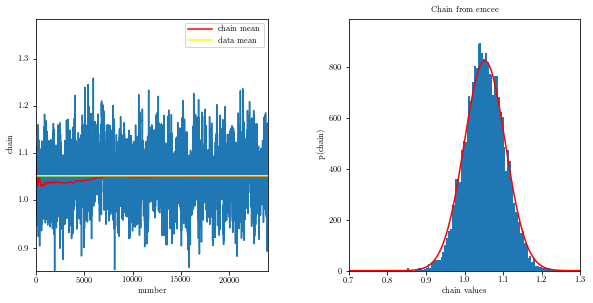

In [15]:
# plot 
fig = plt.figure(figsize=(9, 5))
fig.subplots_adjust(left=0.11, right=0.95, wspace=0.35, bottom=0.18)

chainE = emcee_trace[0]
M = np.size(chainE)

ax1 = fig.add_subplot(121)
xgrid = np.linspace(1,M,M)
plt.plot(xgrid, chainE)
ax1.axis([0, M, np.min(chainE), 1.1*np.max(chainE)])
plt.xlabel('number')
plt.ylabel('chain')
# plot running mean: 
meanC = [np.mean(chainE[:int(N)]) for N in xgrid]
ax1.plot(xgrid, meanC,c='red',label='chain mean') 
ax1.plot(xgrid, 0*xgrid+np.mean(data),c='yellow',label='data mean')
ax1.legend()

ax2 = fig.add_subplot(122)
# skip first Nburn samples
Nburn = 1000
Nchain = np.size(chainE[xgrid>Nburn])
Nhist, bins, patches = plt.hist(chainE[xgrid>Nburn], bins = 'auto', histtype = 'stepfilled')
# plot expectations based on CLT
binwidth = bins[1]-bins[0]
muCLT = np.mean(data)
sigCLT = np.std(data)/np.sqrt(Ndata)
muGrid = np.linspace(0.7, 1.3, 500)
gauss = Nchain*binwidth*stats.norm(muCLT, sigCLT).pdf(muGrid) 
ax2.plot(muGrid, gauss, c='red') 
ax2.set_ylabel('p(chain)')
ax2.set_xlabel('chain values')
ax2.set_xlim(0.7, 1.3)
ax2.set_ylim(0, 1.2*np.max(gauss))
ax2.set_title(r'Chain from emcee')

###  Markov Chain Monte Carlo with PyMC

Now we will use pyMC to get a 2-dimensional posterior pdf 
for location and scale parameters using a sample drawn from 
Cauchy distribution, similar to the distribution we considered earlier using 
brute force grid search method:

 [-----------------100%-----------------] 50000 of 50000 complete in 4.8 sec

(-5, 5)

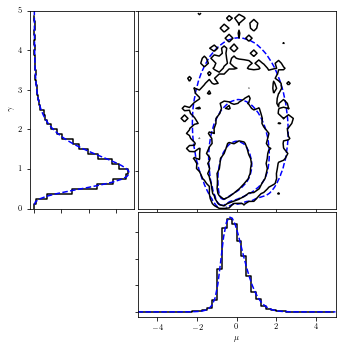

In [16]:
## this is code for the textbook figure 5.22, see
## http://www.astroml.org/book_figures/chapter5/fig_cauchy_mcmc.html

# this fixes a problem when using older versions of pymc with newer
# versions of scipy
import scipy
scipy.derivative = scipy.misc.derivative
import pymc


def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))

#----------------------------------------------------------------------
# Draw the data sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

#----------------------------------------------------------------------
# Perform MCMC with pyMC:

# set up our Stochastic variables, mu and gamma
mu = pymc.Uniform('mu', -5, 5)
log_gamma = pymc.Uniform('log_gamma', -10, 10, value=0)


@pymc.deterministic
def gamma(log_gamma=log_gamma):
    return np.exp(log_gamma)

# set up our observed variable x
x = pymc.Cauchy('x', mu, gamma, observed=True, value=xi)

# set up our model dictionary
model = dict(mu=mu, log_gamma=log_gamma, gamma=gamma, x=x)

# perform the MCMC
S = pymc.MCMC(model)
S.sample(iter=50000, burn=5000)

# extract the traces we're interested in
trace_mu = S.trace('mu')[:]
trace_gamma = S.trace('gamma')[:]
# --- The End of MCMC block using pyMC ---  
#----------------------------------------------------------------------

# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace_mu, trace_gamma,
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

#----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(trace_mu, bins=mu_bins, normed=True)
hist_gamma, bins_gamma = np.histogram(trace_gamma, bins=gamma_bins,
                                      normed=True)


#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(5, 5))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)